In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as ex
import seaborn as sns
%matplotlib inline

In [6]:
transactions = pd.read_csv('../Data/Train/transactions.csv')
transactions.head()

,transaction_id,customer_id,transaction_type,amount,transaction_date,location,device_id,status,is_fraud
0,2251f220c98e4da1adf6b5997b5c5391,bbafa72861294cfb96dfed3aa956bfbf,depôt,8.617840e+05,2010-02-25,"319 Galloway Dale Apt. 613\nNew Kevinbury, IL ...",1d843fad-0117-41bc-8ff2-208cffbac314,échouée,0
1,cb3f318268c246a3b91c96347782aa4f,218ad29d48bf41c3a15aacd26ee19ac0,transfert,4.160409e+06,2007-12-27,"9676 Hoffman Isle Apt. 254\nDaniellechester, H...",a28baef9-1e33-490b-88a7-1b07c54ea485,réussie,0
2,535332f5dd334dc98d85a93bacb76f8c,8787ee3f44624cb7a4569f75c6cefac8,retrait,5.741303e+06,2007-05-17,"096 Christopher Streets\nLake Joshua, CO 60898",a69bbae7-0055-40b5-beff-4b0457f7b52a,réussie,0
3,167733ffec654549bc2f9477f8157b3d,ea0b6e39a32e44028a0e484dd7d5aaa6,retrait,7.992655e+06,2015-08-14,"5496 Donald Roads\nSouth Courtneystad, WY 51100",6ea33d0a-c3cc-411f-bb65-c0c38512867b,réussie,0
4,0b5d7bdeebf5417fb0c3cf54b3825a66,85e37d1bd10641e7b56df0f9fa870fa4,transfert,3.606987e+06,2008-08-30,66933 Smith Grove Suite 162\nNew Stephaniemout...,d83a649c-41ea-4ed3-8038-38193c6308fe,échouée,0


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    100000 non-null  object 
 1   customer_id       100000 non-null  object 
 2   transaction_type  100000 non-null  object 
 3   amount            100000 non-null  float64
 4   transaction_date  100000 non-null  object 
 5   location          100000 non-null  object 
 6   device_id         100000 non-null  object 
 7   status            100000 non-null  object 
 8   is_fraud          100000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 6.9+ MB


In [8]:
transactions.describe(include="all")

,transaction_id,customer_id,transaction_type,amount,transaction_date,location,device_id,status,is_fraud
count,100000,100000,100000,1.000000e+05,100000,100000,100000,100000,100000.000000
unique,100000,10000,3,NaN,6938,1000,63225,2,NaN
top,2251f220c98e4da1adf6b5997b5c5391,63feade088264debab33ddc73f1e2b17,depôt,NaN,2017-04-26,"0899 Dickson Port\nJenningsborough, NJ 06306",6bcb8891-72f5-4494-8d61-184f776c0ab7,échouée,NaN
freq,1,24,33492,NaN,33,132,8,50033,NaN
mean,NaN,NaN,NaN,4.997003e+06,NaN,NaN,NaN,NaN,0.503880
std,NaN,NaN,NaN,2.887396e+06,NaN,NaN,NaN,NaN,0.499987
min,NaN,NaN,NaN,2.646072e+02,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,2.501177e+06,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,5.004852e+06,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,7.496297e+06,NaN,NaN,NaN,NaN,1.000000


changing date type

In [9]:
transactions.transaction_date = pd.to_datetime(transactions.transaction_date)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    100000 non-null  object        
 1   customer_id       100000 non-null  object        
 2   transaction_type  100000 non-null  object        
 3   amount            100000 non-null  float64       
 4   transaction_date  100000 non-null  datetime64[ns]
 5   location          100000 non-null  object        
 6   device_id         100000 non-null  object        
 7   status            100000 non-null  object        
 8   is_fraud          100000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 6.9+ MB


### transaction_type

<Axes: xlabel='transaction_type', ylabel='count'>

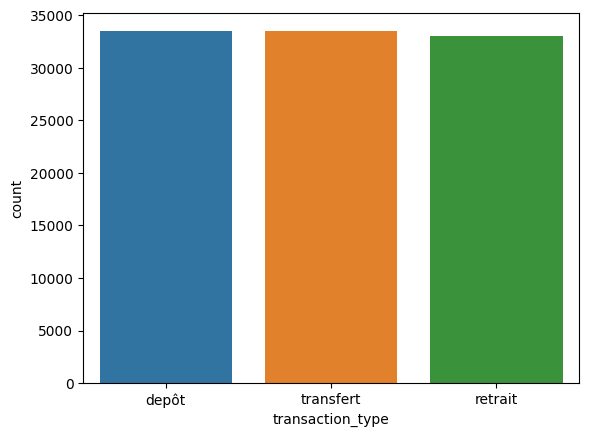

In [16]:
sns.countplot(transactions, x="transaction_type", hue='transaction_type')

In [12]:
transactions.transaction_type.value_counts().sort_values()

transaction_type
retrait      33031
transfert    33477
depôt        33492
Name: count, dtype: int64

In [26]:
length = transactions.shape[0]
# create dataframe percentage of transaction type
proportion = pd.DataFrame(transactions['transaction_type'].value_counts(normalize=True)*100)
proportion

,proportion
transaction_type,
depôt,33.492
transfert,33.477
retrait,33.031


### transaction amount

In [35]:
# transaction amount by transaction type
pd.DataFrame(transactions.groupby('transaction_type').amount.aggregate(['mean', 'median']))

,mean,median
transaction_type,,
depôt,5.011515e+06,5.042304e+06
retrait,5.014341e+06,5.027240e+06
transfert,4.965379e+06,4.948051e+06
